# Programming assignment 3: spotting cars using convolutional neural networks
In this assignment, we will see a few different approaches to building image classifiers using convolutional neural networks.

We have a small image dataset and our task is to train a CNN that can find images that contain cars. CNNs are data-hungry in general and we won't get a fantastic accuracy using this dataset, so as an alternative we'll explore the opportunity to "piggyback" on a pre-trained CNN model for another image classification task.

Purposes of this assignment:

practicing the use of the Keras library for neural network development;
getting some practical experience of working with image data and CNNs;
investigating overfitting in CNNs;
learning how to improve your CNN using data augmentation and transfer learning tricks.
Work in a group up of two or three people. You can choose between (1) submitting the Python code and a short report describing everything you do and all your results, or (2) submitting a single Jupyter notebook including your code and comments as Markdown boxes.

Before submitting, please make sure that:

the names of all members of the group are listed at the beginning of the notebook;
all intermediate steps, results, and your conclusions are described carefully;
the code can be executed in one go without crashing or errors. If you use a notebook, please select Restart & Run All in the Kernel menu before you submit;
Submit the files at the submission page in Canvas.

Deadline: March 11.

Preliminaries
Repeat the lectures (or at least the notebooks) about neural network basics and convolutional neural networks.
Make sure that Keras is installed. You can install by entering conda install tensorflow if using Anaconda. (The most recent version of Keras is bundled with the TensorFlow library.)
If you are installing via pip/pip3 rather than Anaconda, you will need to install h5py as well, if you'd like to be able to save your trained models.
Install the image processing library Pillow, which is needed by the Keras functions that load the images. (conda install pillow or pip3 install Pillow)
Introduction: Loading images from a directory
In this section, we'll see how we can a set of images stored in a directory. Your work here does not need to be included in the report.

First download the package containing the images here and unpack it. These images have been extracted from a dataset included in the PASCAL Visual Object Classes Challenge 2010 (VOC2010).

The structure of the directory is

pa3_images
   train
      car   [800 images]
      other [800 images]
   validation
      car   [288 images]
      other [288 images]
so as you can see, the images have already been split into a training and a validation set, and each subset contains a separate directory for each of the two classes (car and other). The class other contains images of various objects.

Keras includes a function load_img to load a single image, but we'll use a more practical approach for this assignment.

We first declare an ImageDataGenerator. This is an object that defines how images should be converted into NumPy data. In our case, we add a parameter rescale; this means that the color values range from 0 to 1 instead of 0 to 255. (This transformation is similar to a scaler in scikit-learn and has a similar purpose.)

In [636]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

data_gen = ImageDataGenerator(rescale=1.0/255)

Now, let's read the images in the training set. By calling flow_from_directory, we apply the ImageDataGenerator to transform the images stored in a directory. This will return a generator object that loads images, transforms them, and returns them in batches of a given size.

The parameters used here are:

the location of the training images;
target_size is for the size of the images: in our case, we'll resize them so that they are all 64x64 pixels;
batch_size refers to the batch size we'll use when training;
class_mode='binary' means that we'll treat the learning problem as a binary classification problem;
classes is provided to make sure that other is coded as 0 and car as 1;
seed is an arbitrary integer that initializes the random number generator for reproducibility;
shuffle because we'd like the images to appear in a random order when training.
If you have a severe performance problem, you can resize the images to some size smaller than 64x64. This is likely to give you a slightly lower classification accuracy. (Conversely, if you have a high-end machine, you may consider increasing the image size.)

In [637]:
imgdir = 'pa3_images' # or wherever you put them...
img_size = 64
batch_size = 32

train_generator = data_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 1600 images belonging to 2 classes.


We'll take a look at a few images. We first read one batch from the generator. This will return a part of the training data: some images, and the corresponding labels (0 for other, 1 for car).

In [638]:
Xbatch, Ybatch = train_generator.next()

What is the form of the images in the batch? We take a look at the NumPy object that was returned. It is a four-dimensional NumPy array (formally, a four-dimensional tensor).

The dimensions are

32, because there are 32 images in the batch
64, for the height of each image
64, for the width of each image
3, because for each pixel we store the red, green, and blue value (a value between 0 and 1)

In [639]:
Xbatch.shape

(32, 64, 64, 3)

In [640]:
Xbatch[4].shape

(64, 64, 3)

We'll take a look at the first instance. First, let's check whether this is a car or not. In my case, the label is 0 for the first instance, meaning that this is not a car. This doesn't have to be the case for you, because the images appear in a random order (shuffle=True).

In [641]:
Ybatch[4]

1.0

Draw the image using plt.imshow. (Assuming you have imported matplotlib.pyplot as plt.) As usual when plotting, you'll need to call plt.show() or plt.savefig(), or use an interactive notebook, to see something.

Hopefully, you can confirm from the image whether this is a car or not (and this should agree with Ybatch[0]). It might be a bit hard to see, because we resized the image to 64x64.

In [642]:
from matplotlib import pyplot as plt

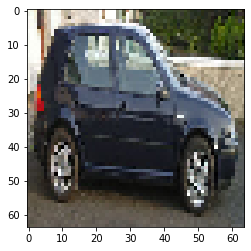

In [643]:
plt.imshow(Xbatch[4]);

# Part 1: Training a convolutional neural network
Write a function make_convnet that builds a convolutional neural network.

The input shape should be (img_size, img_size, 3), where img_size is the image size we defined above (such as 64), and 3 is for the red, green, and blue "channels" of the image. If you make use of the code we saw during the lecture, please note that this is a binary classification problem, so it's probably good to change the output layer and use another loss function.

Also remember to select a suitable optimizer.

Before you can train the CNN, you need to make a second data generator for the generation of validation images. You should again use data_gen.flow_from_directory, but use the validation directory instead of the training directory.

Now we have everything that we need to train the CNN. Call fit to train the model.

In most cases, training will be fairly time-consuming. The exact amount needed will depend on your machine, how you constructed your CNN, and how many epochs you let it train. Typically, training will take a few minutes.

Optionally, call your_cnn.save_weights(some_file_name) after training. This will save your weights to a file; you can recover them later using your_cnn.load_weights(the_same_file_name), so that you can run your CNN several times without having to re-train every time.

Hint: Depending on how you build your CNN, you will see different accuracies. The dataset is balanced, so a majority-class dummy baseline would have an accuracy of 0.5. Let's hope you can get a better result than that. The validation set is a bit small because we don't have that much data, so you will probably see some fluctuation in the accuracy values.

Plot the training and validation loss for each epoch. Also plot the training and validation accuracies in another plot.

If you need to run the model on a dataset that you access via a generator, you can use evaluate. The loss function and the accuracy will be computed. (As you can see, these values are the same as you got in the last epoch when training.)

In [644]:
validation_img = data_gen.flow_from_directory(
        imgdir + '/validation',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 576 images belonging to 2 classes.


In [645]:
Xtest, Ytest = validation_img.next()

In [646]:
Xtest.shape

(32, 64, 64, 3)

In [647]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D 
import tensorflow.keras.backend as K

def make_convent(img_size, d, classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(img_size,img_size, d)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(classes, activation='sigmoid'))
    return model


In [648]:
model=make_convent(img_size, 3, 1)

In [649]:
model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 60, 60, 32)        2432      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 26, 26, 32)        25632     
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_79 (Dense)             (None, 128)               692352    
_________________________________________________________________
dense_80 (Dense)             (None, 1)               

In [650]:
model.compile(loss='binary_crossentropy',optimizer = 'adam',  metrics = ['accuracy'])  

In [651]:
h1 = model.fit_generator(train_generator,verbose=1, epochs=30,validation_data=validation_img, class_weight=32)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate for 18 steps
Epoch 1/30
50/50 [==============================] - 14s 270ms/step - loss: 0.6874 - accuracy: 0.5594 - val_loss: 0.6069 - val_accuracy: 0.7014
Epoch 2/30
50/50 [==============================] - 13s 256ms/step - loss: 0.6081 - accuracy: 0.6850 - val_loss: 0.5552 - val_accuracy: 0.7274
Epoch 3/30
50/50 [==============================] - 12s 247ms/step - loss: 0.5608 - accuracy: 0.7300 - val_loss: 0.5291 - val_accuracy: 0.7552
Epoch 4/30
50/50 [==============================] - 13s 254ms/step - loss: 0.5096 - accuracy: 0.7613 - val_loss: 0.5146 - val_accuracy: 0.7622
Epoch 5/30
50/50 [==============================] - 13s 254ms/step - loss: 0.4654 - accuracy: 0.7912 - val_loss: 0.5234 - val_accuracy: 0.7674
Epoch 6/30
50/50 [==============================] - 13s 250ms/step - loss: 0.4318 - accuracy: 0.8075 - val_loss: 0.5273 - val_accuracy: 0.7587
Epoch 7/30
50/50 [==============================] 

In [652]:
model.save_weights('weights.txt')

In [665]:
score = model.evaluate(validation_img, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

  ...
    to  
  ['...']
Test loss: 0.45972517132759094
Test accuracy: 0.8072917


In [654]:
print(max(h.history["val_accuracy"]))

0.7951389


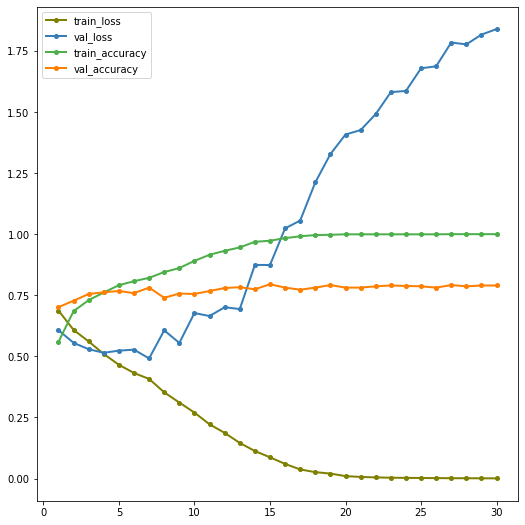

In [655]:
fig=plt.figure(figsize=(19,20))
ax1=fig.add_subplot(2,2,1)
data=np.arange(1, 31) 
ax1.plot(data, h.history["loss"], color='olive',marker='o', markerfacecolor='olive', markersize=4, linewidth=2,label='train_loss')
ax1.plot(data, h.history["val_loss"], color='#377eb8',marker='o', markerfacecolor='#377eb8', markersize=4, linewidth=2,label='val_loss')
ax1.plot(data, h.history["accuracy"], color='#4daf4a',marker='o', markerfacecolor='#4daf4a', markersize=4, linewidth=2,label='train_accuracy')
ax1.plot(data, h.history["val_accuracy"], color='#ff7f00',marker='o', markerfacecolor='#ff7f00', markersize=4, linewidth=2,label='val_accuracy')
ax1.legend()

# Part 2: Data augmentation
Most likely, unless you applied early stopping very aggressively, you saw some overfitting in your solution.

One approach to reducing the risk of overfitting to the training set is to apply data augmentation. This means that we create additional training instances by applying different types of modifications to the existing training images.

Take a look at the documentation of ImageDataGenerator. Several of the optional parameters enable different types of data augmentation, such as rotation, mirroring, and changing the colors.

Make a new ImageDataGenerator that applies data augmentation to the training images.

Make a new training data generator that uses the new ImageDataGenerator, instead of the generator data_gen we originally used, and retrain your model. (Note: The generator for reading the validation data should not use data augumentation.)

Do you see an improvement on the validation set?

Hint: If you play around with different types of data augmentation you will notice that there's a tradeoff between underfitting and overfitting. Typically, if you tune your augmentation carefully you will see a small improvement, but this will of course depend on how you built your CNN. Also, keep in mind that our validation set is tiny, so we see quite a bit of fluctuation in our evaluations. So even if the data augmentation has actually improved your classifier, it might be hard to discern the effect.

Again, plot the losses and accuracies. Do you see any change?



In [656]:
datagen = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,height_shift_range=0.1,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest',rescale=1.0/255)

In [657]:
traingenerator = datagen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 1600 images belonging to 2 classes.


In [658]:
XbatchRe, YbatchRe = traingenerator.next()

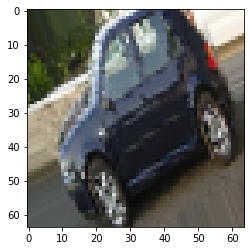

In [659]:
plt.imshow(XbatchRe[4]);

In [661]:
h = model.fit_generator(traingenerator,verbose=1, epochs=30,validation_data=validation_img, class_weight=32)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate for 18 steps
Epoch 1/30
50/50 [==============================] - 16s 317ms/step - loss: 1.1167 - accuracy: 0.6237 - val_loss: 0.7534 - val_accuracy: 0.6667
Epoch 2/30
50/50 [==============================] - 17s 330ms/step - loss: 0.6320 - accuracy: 0.6538 - val_loss: 0.6190 - val_accuracy: 0.7014
Epoch 3/30
50/50 [==============================] - 14s 285ms/step - loss: 0.5877 - accuracy: 0.6950 - val_loss: 0.5775 - val_accuracy: 0.7483
Epoch 4/30
50/50 [==============================] - 14s 282ms/step - loss: 0.5555 - accuracy: 0.7269 - val_loss: 0.5793 - val_accuracy: 0.7014
Epoch 5/30
50/50 [==============================] - 15s 298ms/step - loss: 0.5299 - accuracy: 0.7444 - val_loss: 0.5334 - val_accuracy: 0.7500
Epoch 6/30
50/50 [==============================] - 14s 283ms/step - loss: 0.4978 - accuracy: 0.7563 - val_loss: 0.5230 - val_accuracy: 0.7552
Epoch 7/30
50/50 [==============================] 

In [663]:
score = model.evaluate(validation_img, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(h.history.keys())

  ...
    to  
  ['...']
Test loss: 0.45972517132759094
Test accuracy: 0.8072917
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


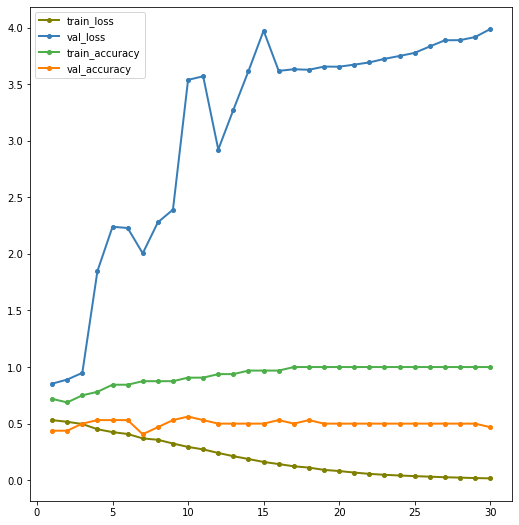

In [662]:
fig=plt.figure(figsize=(19,20))
ax1=fig.add_subplot(2,2,1)
data=np.arange(1, 31) 
ax1.plot(data, d.history["loss"], color='olive',marker='o', markerfacecolor='olive', markersize=4, linewidth=2,label='train_loss')
ax1.plot(data, d.history["val_loss"], color='#377eb8',marker='o', markerfacecolor='#377eb8', markersize=4, linewidth=2,label='val_loss')
ax1.plot(data, d.history["accuracy"], color='#4daf4a',marker='o', markerfacecolor='#4daf4a', markersize=4, linewidth=2,label='train_accuracy')
ax1.plot(data, d.history["val_accuracy"], color='#ff7f00',marker='o', markerfacecolor='#ff7f00', markersize=4, linewidth=2,label='val_accuracy')
ax1.legend()

Interlude: Applying a pre-trained convolutional neural network
One of the most famous image databases used in computer vision is called ImageNet. It contains a very large number of categories and an even larger number of example images for each category. This is one of the standard benchmarks in the field.

Several CNNs that have been trained on ImageNet have been released to the public, and Keras includes several of them. In this exercise, we'll use the model called VGG-16, which was developed by a group at the university of Oxford. Here is a description of VGG-16.

We use the built-in function in Keras to build the VGG-16 model and load the weights. Here, weights='imagenet' means that we use the pre-trained weights, and include_top=True that we use the full classification model.

The first time you execute this code, the VGG-16 model will be downloaded. (It will then be stored on your disk for future use.)

In [666]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input

vggmodel = applications.VGG16(weights='imagenet', include_top=True)

In [667]:
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [668]:
imageTrain=load_img('./pa3_images/train/car/0004.jpg', target_size=(224,224))

In [669]:
imageTest=load_img('./pa3_images/validation/other/0012.jpg', target_size=(224,224))

In [670]:
imageTrain = img_to_array(imageTrain)

In [671]:
imageTrain = np.expand_dims(imageTrain, axis=0)

In [672]:
imageTrain.shape

(1, 224, 224, 3)

In [673]:
imageTest = img_to_array(imageTest)

In [674]:
imageTrain=preprocess_input(imageTrain)

In [675]:
imageTest=preprocess_input(imageTest)

In [676]:
imageTrain = imageTrain.reshape(1, 224, 224, 3)

In [677]:
imageTrain.shape

(1, 224, 224, 3)

In [678]:
imageTest = imageTest.reshape(1, 224, 224, 3)

In [679]:
features = vggmodel.predict(imageTrain)

In [680]:
features.shape

(1, 1000)

In [681]:
print('Predicted:', decode_predictions(features, top=10)[0])

Predicted: [('n03930630', 'pickup', 0.6246942), ('n04461696', 'tow_truck', 0.21569963), ('n02930766', 'cab', 0.11638441), ('n02814533', 'beach_wagon', 0.00987275), ('n03459775', 'grille', 0.005154153), ('n04252225', 'snowplow', 0.005060414), ('n03100240', 'convertible', 0.0048265723), ('n02974003', 'car_wheel', 0.003293323), ('n03345487', 'fire_engine', 0.0029164401), ('n02701002', 'ambulance', 0.002424785)]


# Part 3: Using VGG-16 as a feature extractor
Let's return to the problem of finding images of cars.

Since we just have 1,600 training images, the CNN we trained earlier wasn't fantastically successful. We'll now take a different approach, inspired by the paper by Razavian et al. (2014): we'll use the VGG-16 model as a feature extractor: we'll apply the convolutional part of the VGG-16 model to our images, and use this output as the input of our own classifier. This solution is an example of transfer learning, which means that we leverage the knowledge stored in a pre-trained model and apply it to our specific task.

To get started, we load the VGG-16 model once more. Please note that the parameters are a bit different this time:

include_top=False because we won't use the highest layers in the ImageNet classifier. Instead, we'll train our own classifier.
We specify an input_shape that overrides the 224x224 size that is the default size used by VGG-16. For the purpose of comparing to our previous results, we'll use the same size as in our first CNN classifier.

In [682]:
feature_extractor = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

In [683]:
feature_extractor.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

#Add Layers

In [684]:
def make_output(base_model,num_class):
    feature= Sequential() 
    feature.add(Flatten(input_shape=base_model.output_shape[1:]))
    feature.add(Dense(units=1000,activation="relu"))
    feature.add(Dense(units=1000,activation="relu"))
    feature.add(Dense(units=num_class, activation="softmax"))
    return feature

In [685]:
feature=make_output(feature_extractor, 2)

In [686]:
feature.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_35 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_81 (Dense)             (None, 1000)              2049000   
_________________________________________________________________
dense_82 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_83 (Dense)             (None, 2)                 2002      
Total params: 3,052,002
Trainable params: 3,052,002
Non-trainable params: 0
_________________________________________________________________


In [687]:
vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [688]:
def create_vgg16_features(SOME_FILE_NAME, folder):
    traindata=vgg_data_gen.flow_from_directory(imgdir + folder , target_size=(img_size, img_size), batch_size=batch_size, class_mode='binary', classes=['other', 'car'], seed=12345, shuffle=False)
    cnn_features=feature_extractor.predict(traindata)
    with open(SOME_FILE_NAME, 'wb') as f:
         np.save(f, cnn_features)

    

In [689]:
create_vgg16_features('train_vgg16', '/train')

Found 1600 images belonging to 2 classes.


In [690]:
create_vgg16_features('validation_vgg16', '/validation')

Found 576 images belonging to 2 classes.


In [691]:
def get_labels(n):
    return np.array([0]*(n//2) + [1]*(n//2))  
def train_on_cnnfeatures(SOME_FILE_NAME1,SOME_FILE_NAME2):
    feature= Sequential() 
    feature.add(Dense(units=1000,activation="relu"))
    feature.add(Dense(units=1000,activation="relu"))
    feature.add(Dense(units=2, activation="softmax")) 
    feature.compile(loss='sparse_categorical_crossentropy',optimizer = 'adam',  metrics = ['accuracy'])  
    
    with open(SOME_FILE_NAME1, 'rb') as f:
        train_data = np.load(f)
        traindata=train_data.reshape(1600,2048)
        
    
    with open(SOME_FILE_NAME2, 'rb') as f:
        validation_data = np.load(f)
        validationdata=validation_data.reshape(576,2048)

    
    
    return feature
    
  

In [696]:

feature=train_on_cnnfeatures('train_vgg16','validation_vgg16')
d=feature.fit(traindata, get_labels(1600), batch_size=32, epochs=50, verbose=1, validation_data=(validationdata, get_labels(576)))

Train on 1600 samples, validate on 576 samples
Epoch 1/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 4.1198 - accuracy: 0.8356 - val_loss: 0.7538 - val_accuracy: 0.8715
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.1335 - accuracy: 0.9588 - val_loss: 0.6560 - val_accuracy: 0.8993
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.0597 - accuracy: 0.9831 - val_loss: 0.5131 - val_accuracy: 0.9045
Epoch 4/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.5294 - val_accuracy: 0.9167
Epoch 5/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 5.8373e-04 - accuracy: 1.0000 - val_loss: 0.5626 - val_accuracy: 0.9201
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 2.2712e-04 - accuracy: 1.0000 - val_loss: 0.5634 - val_accuracy: 0.9219
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample

AttributeError: 'History' object has no attribute 'fit'

In [700]:
print('Test loss:',d.history["val_loss"][-1])
print('Test accuracy:', d.history["val_accuracy"][-1])

Test loss: 1.268847417500284
Test accuracy: 0.9079861


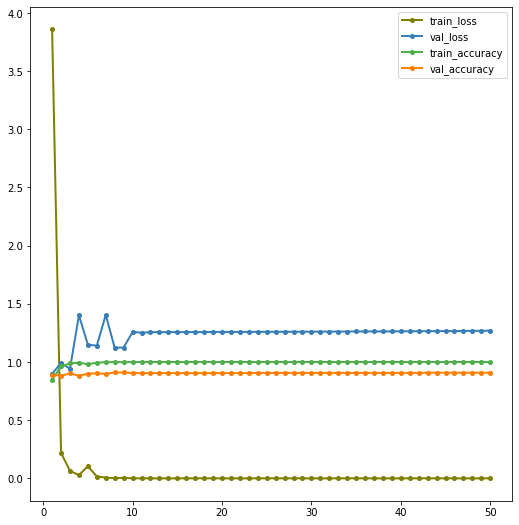

In [701]:
fig=plt.figure(figsize=(19,20))
ax1=fig.add_subplot(2,2,1)
data=np.arange(1, 51) 
ax1.plot(data, d.history["loss"], color='olive',marker='o', markerfacecolor='olive', markersize=4, linewidth=2,label='train_loss')
ax1.plot(data, d.history["val_loss"], color='#377eb8',marker='o', markerfacecolor='#377eb8', markersize=4, linewidth=2,label='val_loss')
ax1.plot(data, d.history["accuracy"], color='#4daf4a',marker='o', markerfacecolor='#4daf4a', markersize=4, linewidth=2,label='train_accuracy')
ax1.plot(data, d.history["val_accuracy"], color='#ff7f00',marker='o', markerfacecolor='#ff7f00', markersize=4, linewidth=2,label='val_accuracy')
ax1.legend()

# Part 4: Visualizing the learned features
The first convolutional layer represents the most low-level patterns that the model looks for in images. We will now visualize these features in the VGG-16 model. (You can also repeat the exercise using your own original model, but because we have so little data, the features in this model may look less like interpretable patterns.)

We get the weights in this convolutional layer. This is a four-dimensional NumPy tensor: width x height x colors x number of convolutions.

In [702]:
first_layer_weights = vggmodel.get_weights()[0]
first_layer_weights.shape

(3, 3, 3, 64)

We create a utility function that will help us visualize the patterns extracted by the first convolutional layer.

This function takes three inputs: the layer's weight tensor (from the step above), a number referring to which convolutional filter we are considering (0-63), and finally a boolean (True/False) value that says whether we want to see the positive or the negative part of this filter. (That is, if positive=True, we see the patterns which enable this "feature"; if it is False, we see the patterns that disable it.)

In [703]:
def kernel_image(weights, i, positive):
    
    # extract the convolutional kernel at position i
    k = weights[:,:,:,i].copy()
    if not positive:
        k = -k
    
    # clip the values: if we're looking for positive
    # values, just keep the positive part; vice versa
    # for the negative values.
    k *= k > 0

    # rescale the colors, to make the images less dark
    m = k.max()
    if m > 1e-3:
        k /= m 

    return k

In [704]:
k_pos=kernel_image(first_layer_weights,0,True)

In [705]:
k_neg=kernel_image(first_layer_weights,0,False)

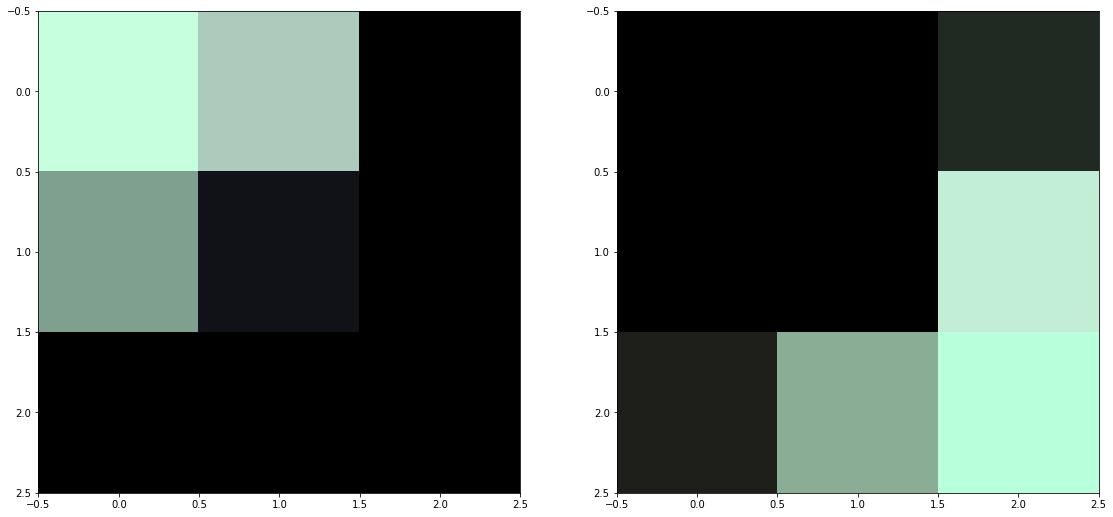

In [708]:
fig=plt.figure(figsize=(19,20))
ax1=fig.add_subplot(2,2,1)
ax1.imshow(k_pos)
ax2=fig.add_subplot(2,2,2)
ax2.imshow(k_neg)